## The MultiONet method for Parametric PDEs
- Implementation is also available in Kaggle notebook:[https://www.kaggle.com/code/yhzang32/multionet4darcyflow-singular](https://www.kaggle.com/code/yhzang32/multionet4darcyflow-singular)
- Datasets in the lesson are available through: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

## (1) Problem description
The Darcy's problem is considered as follows:
\begin{equation}
\begin{split}
-\nabla\cdot(a\nabla u) &= f \\
u &= 0
\end{split}
\end{equation}
The goal of the parametric PDE problem is to learn a mapping from the **piecewise-constant** PDE coefficient $a$ to the solution $u$, i.e.,:
$$
\mathcal{G}: a(x)\in\mathcal{A}\rightarrow u(x)\in\mathcal{U}
$$

<KeysViewHDF5 ['X', 'Y', 'coeff', 'sol']>
The shape of a_train: torch.Size([1000, 841])
The shape of u_train: torch.Size([1000, 841])
The shape of x_train: torch.Size([841, 2])


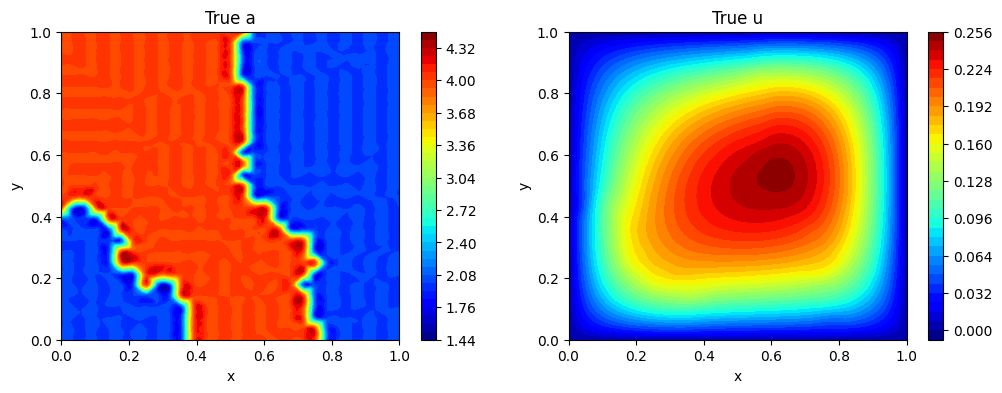

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
def setup_seed(seed):
     torch.manual_seed(seed)
     torch.cuda.manual_seed_all(seed)
     np.random.seed(seed)
     torch.backends.cudnn.deterministic = True
setup_seed(3407)
device = 'cuda'
dtype = torch.float32
######################################
# Load training data
######################################
data_train = h5py.File('DarcyFlow_Singular_train.mat', 'r')
data_test = h5py.File('DarcyFlow_Singular_test.mat', 'r')
print(data_train.keys()) 
#
def get_data(data, ndata=1000):
    # The labeled training data (a,u)
    a = np.array(data["coeff"][...,:ndata])
    u = np.array(data["sol"][:,:ndata])
    # The coordinates
    x1, x2 = np.array(data['X']), np.array(data['Y'])
    mesh = np.vstack([x1.ravel(), x2.ravel()]).T
    gridx = mesh.reshape(-1, 2)
    #
    a = torch.tensor(a, dtype=dtype).reshape(ndata, -1)
    u = torch.tensor(u, dtype=dtype).reshape(ndata, -1)
    x = torch.tensor(gridx, dtype=dtype)
    return a, u, x, gridx
a_train, u_train, x_train, gridx = get_data(data_train, ndata=1000)
a_test, u_test, x_test, gridx = get_data(data_test, ndata=200)
print('The shape of a_train:', a_train.shape)
print('The shape of u_train:', u_train.shape)
print('The shape of x_train:', x_train.shape)

####### Visualize the training data 
a_show, u_show = a_train[0], u_train[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(a_show), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True a')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_show), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

## (2) The MultiONet architecture

In [2]:
import torch.nn as nn
#
class SiLU_Sin(nn.Module):

    def __init__(self):
        super(SiLU_Sin, self).__init__()
        self.main_act = nn.SiLU()

    def forward(self, x):
        x1 = torch.sin(np.pi * (x+1.))

        return self.main_act(x1) + x

class SiLU_Id(nn.Module):

    def __init__(self):
        super(SiLU_Id, self).__init__()
        self.main_act = nn.SiLU()

    def forward(self, x):

        return self.main_act(x) + x
#
class MultiONet(nn.Module):
    
    def __init__(self, in_size_x, in_size_a, hidden_list, dtype):
        super(MultiONet, self).__init__()
        # The activations
        self.activation_trunk = SiLU_Sin()
        self.activation_branch = SiLU_Id()
            
        # The input layer: 
        self.fc_x_in = nn.Linear(in_size_x, hidden_list[0], dtype=dtype)
        self.fc_a_in = nn.Linear(in_size_a, hidden_list[0], dtype=dtype)
        
        # The hidden layer
        net_x, net_a = [], []
        self.hidden_in = hidden_list[0]
        for hidden in hidden_list:
            net_x.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            net_a.append(nn.Linear(self.hidden_in, hidden, dtype=dtype))
            self.hidden_in =  hidden 
        self.net_x = nn.Sequential(*net_x)
        self.net_a = nn.Sequential(*net_a)
        
        # Weights and bias
        self.w = torch.nn.ParameterList(
            [torch.nn.Parameter(torch.tensor(0.0)) for _ in range(len(hidden_list))]
            )
        self.b = torch.nn.Parameter(torch.tensor(0.0, dtype=dtype))
        
    def forward(self, x, a):
        ''' 
        Input:
            x: size(mesh_size, x_size)
            a: size(batch_size, a_size)
        '''
        #### THe input layer
        # size(mesh_size, hidden_size)
        x = self.activation_trunk(self.fc_x_in(x))
        # size(n_batch, hidden_size)
        a = self.activation_branch(self.fc_a_in(a))
        
        #### The conv layer
        out = 0. 
        for net_t, net_b, w in zip(self.net_x, self.net_a, self.w):
            # size(mesh_size, x_size) -> size(mesh_size, p)
            x = self.activation_trunk(net_t(x))
            # size(batch_size, a_size) -> size(batch_size, p)
            a = self.activation_branch(net_b(a))
            #
            out += torch.einsum('bh,mh->bm', a, x) * w 
            
        ##### The output layer
        out = out/len(self.net_x) + self.b

        return out
#
hidden_list = [128, 128, 128]
#
model_u = MultiONet(2, 841, hidden_list, dtype).to(device)
#
from torchsummary import summary
summary(model_u, [(2,), (841,)], device=device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              SiLU-2                  [-1, 128]               0
          SiLU_Sin-3                  [-1, 128]               0
            Linear-4                  [-1, 128]         107,776
              SiLU-5                  [-1, 128]               0
           SiLU_Id-6                  [-1, 128]               0
            Linear-7                  [-1, 128]          16,512
              SiLU-8                  [-1, 128]               0
          SiLU_Sin-9                  [-1, 128]               0
           Linear-10                  [-1, 128]          16,512
             SiLU-11                  [-1, 128]               0
          SiLU_Id-12                  [-1, 128]               0
           Linear-13                  [-1, 128]          16,512
             SiLU-14                  [

### (3) The loss function
$$
L(\theta) = \frac{1}{N_{\text{data}}} \sum_{i=1}^{N_{\text{data}}} \sqrt{\sum_{j=1}^{N_p} \left| \mathcal{G}_\theta(a^{(i)}(\Xi))(x_j) - u^{(i)}(x_j) \right|^2}
$$

In [3]:
# The normalizer for inputs and outputs
class UnitGaussianNormalizer():

    def __init__(self, a, eps=1e-8):
        super(UnitGaussianNormalizer, self).__init__()
        '''Apply normaliztion to inputs or outputs
        Input:
            a: size(N, mesh_size)
        Output:
            mean: size(mesh_szie,)
            std: size(mesh_size,)
        '''
        self.mean = torch.mean(a, 0)
        self.std = torch.std(a, 0)
        self.eps = eps
    
    def encode(self, a):
        '''
        Input:
            a: a: size(N, mesh_size)
        '''
        return (a - self.mean) / (self.std + self.eps)
    
    def decode(self, a):
        #
        return a * (self.std + self.eps) + self.mean
#
normalizer_a = UnitGaussianNormalizer(a_train.to(device))
normalizer_u = UnitGaussianNormalizer(u_train.to(device))

# The loss function
class LossClass(object):

    def __init__(self, u_model):
        self.device = device
        self.u_model = u_model 
    
    def loss_data(self, a_batch, u_batch):
        '''loss term'''
        x, a, u = x_train.to(self.device), a_batch.to(self.device), u_batch.to(self.device)
        # with normalizer
        a_norm = normalizer_a.encode(a)
        u_pred_norm = self.u_model(x, a_norm)
        u_pred = normalizer_u.decode(u_pred_norm) 
        #
        loss = torch.norm(u-u_pred, 2, 1)
        loss = torch.mean(loss)
        
        return loss 

    def get_error(self, a, u):
        '''L2 relative error'''
        x, a, u = x_train.to(self.device), a.to(self.device), u.to(self.device)
        # with normalizer
        a_norm = normalizer_a.encode(a)
        u_pred_norm = self.u_model(x, a_norm)
        u_pred = normalizer_u.decode(u_pred_norm) 
        #
        error = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)

        return torch.mean(error)

### (4) Training the model

In [4]:
from tqdm import trange
from torch.utils.data import Dataset, DataLoader
import time
############# Define your own dataset 
class MyDataset(Dataset):

    def __init__(self, a:torch.tensor, u:torch.tensor):
        '''
        Input:
            a: size(batch_size, a_size)
            u: size(batch_size, u_size)
        '''
        self.a = a 
        self.u = u
    
    def __getitem__(self, index):
        return self.a[index], self.u[index]

    def __len__(self):
        return self.a.shape[0]
        
train_loader = DataLoader(MyDataset(a_train, u_train), batch_size=50, shuffle=True)


################# Training setups
epochs = 2000
lr = 1e-3
optimizer = torch.optim.Adam(params=model_u.parameters(), lr=lr, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=np.int32(epochs/5), gamma=0.5)
loss_list, error_list = [], []
t0 = time.time()
for epoch in trange(epochs):
    loss = 0.
    for a_batch, u_batch in train_loader:
        lossClass = LossClass(model_u)
        loss_train = lossClass.loss_data(a_batch, u_batch)
        #
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()
        #
        loss += loss_train
    #
    scheduler.step()  # Adjust learning rate
    with torch.no_grad():
        error = lossClass.get_error(a_test, u_test)
        error_list.append(error.item())
    #
    loss = loss/len(train_loader)
    loss_list.append(loss.item())
    if (epoch+1)%100==0:
        print(f'Epoch:{epoch}, The loss is:{loss.item()}')
        print('error_test:', error_list.pop())
print('The consuming time is:', time.time()-t0)

  5%|███▉                                                                          | 101/2000 [00:09<02:49, 11.24it/s]

Epoch:99, The loss is:0.04921673238277435
error_test: 0.01482856273651123


 10%|███████▊                                                                      | 201/2000 [00:18<02:40, 11.24it/s]

Epoch:199, The loss is:0.04224632307887077
error_test: 0.013597344979643822


 15%|███████████▋                                                                  | 301/2000 [00:26<02:31, 11.23it/s]

Epoch:299, The loss is:0.04042424261569977
error_test: 0.01328185759484768


 20%|███████████████▋                                                              | 401/2000 [00:35<02:23, 11.18it/s]

Epoch:399, The loss is:0.03790770098567009
error_test: 0.013176292181015015


 25%|███████████████████▌                                                          | 501/2000 [00:44<02:13, 11.23it/s]

Epoch:499, The loss is:0.03239934518933296
error_test: 0.01205800287425518


 30%|███████████████████████▍                                                      | 601/2000 [00:53<02:01, 11.48it/s]

Epoch:599, The loss is:0.030725587159395218
error_test: 0.011794738471508026


 35%|███████████████████████████▎                                                  | 701/2000 [01:02<01:55, 11.22it/s]

Epoch:699, The loss is:0.030384764075279236
error_test: 0.011780907399952412


 40%|███████████████████████████████▏                                              | 801/2000 [01:11<01:46, 11.22it/s]

Epoch:799, The loss is:0.029666846618056297
error_test: 0.01175760943442583


 45%|███████████████████████████████████▏                                          | 901/2000 [01:20<01:38, 11.21it/s]

Epoch:899, The loss is:0.027948761358857155
error_test: 0.0114813894033432


 50%|██████████████████████████████████████▌                                      | 1001/2000 [01:29<01:29, 11.21it/s]

Epoch:999, The loss is:0.027560902759432793
error_test: 0.011388859711587429


 55%|██████████████████████████████████████████▍                                  | 1101/2000 [01:38<01:20, 11.22it/s]

Epoch:1099, The loss is:0.02726994827389717
error_test: 0.011376154609024525


 60%|██████████████████████████████████████████████▏                              | 1201/2000 [01:47<01:11, 11.23it/s]

Epoch:1199, The loss is:0.027049852535128593
error_test: 0.01133398525416851


 65%|██████████████████████████████████████████████████                           | 1301/2000 [01:56<01:02, 11.22it/s]

Epoch:1299, The loss is:0.02634964883327484
error_test: 0.011242743581533432


 70%|█████████████████████████████████████████████████████▉                       | 1401/2000 [02:04<00:53, 11.24it/s]

Epoch:1399, The loss is:0.026159832254052162
error_test: 0.011245755478739738


 75%|█████████████████████████████████████████████████████████▊                   | 1501/2000 [02:13<00:44, 11.24it/s]

Epoch:1499, The loss is:0.026034647598862648
error_test: 0.011220226064324379


 80%|█████████████████████████████████████████████████████████████▋               | 1601/2000 [02:22<00:35, 11.25it/s]

Epoch:1599, The loss is:0.025717804208397865
error_test: 0.011214656755328178


 85%|█████████████████████████████████████████████████████████████████▍           | 1701/2000 [02:31<00:26, 11.24it/s]

Epoch:1699, The loss is:0.025498617440462112
error_test: 0.011185974813997746


 90%|█████████████████████████████████████████████████████████████████████▎       | 1801/2000 [02:40<00:17, 11.24it/s]

Epoch:1799, The loss is:0.025381503626704216
error_test: 0.011170231737196445


 95%|█████████████████████████████████████████████████████████████████████████▏   | 1901/2000 [02:49<00:08, 11.25it/s]

Epoch:1899, The loss is:0.02527601085603237
error_test: 0.011166493408381939


100%|█████████████████████████████████████████████████████████████████████████████| 2000/2000 [02:58<00:00, 11.23it/s]

Epoch:1999, The loss is:0.025207823142409325
error_test: 0.01116676814854145
The consuming time is: 178.15549874305725


### (5) Performance on testing dataset
The relative error:
$$
L^2 = \sqrt{\sum_i\frac{\|u(x_i)-u_{nn}(x_i)\|^2}{\|u(x_i)\|^2}}
$$
where $u$ represents the true solution and $u_{nn}$ is the network approximation.

The shape of u_pred: torch.Size([200, 841])
The average l2 error: tensor(0.0112)


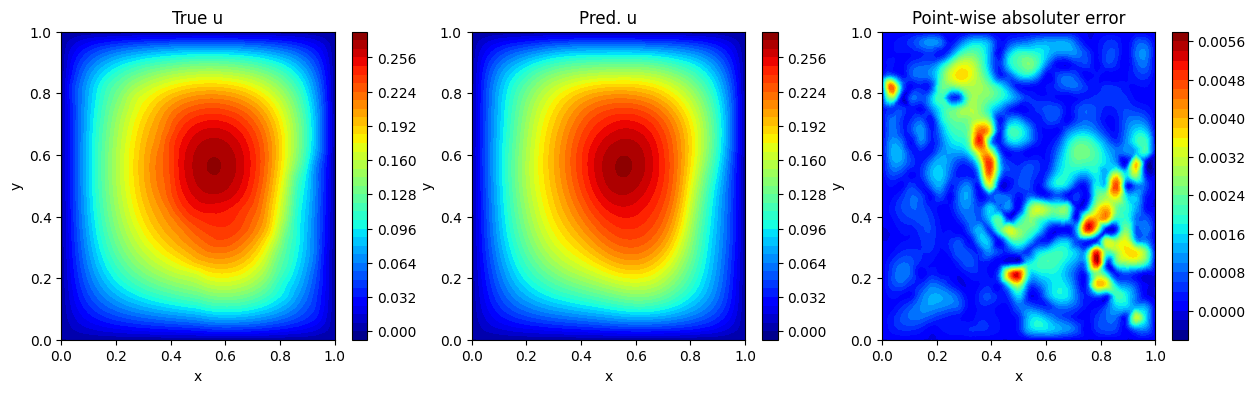

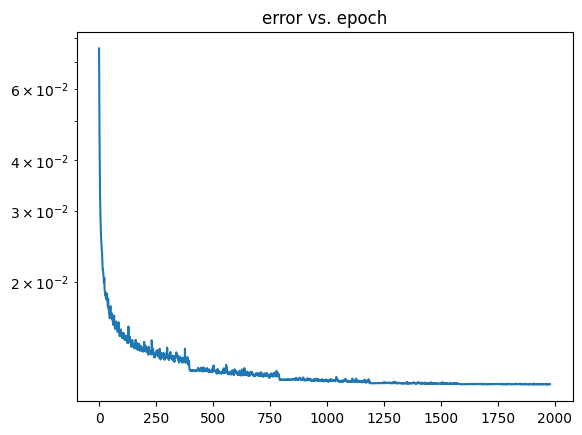

In [5]:
#######################################
# The L2 relative error
#######################################
def L2_error(u, u_pred):
    ''' '''
    l2 = torch.norm(u-u_pred, 2, 1) / torch.norm(u, 2, 1)
    return l2
# Make prediction with trained model
# with normalizer
a_test_norm = normalizer_a.encode(a_test.to(device))
u_test_pred_norm = model_u(x_test.to(device), a_test_norm)
u_test_pred = normalizer_u.decode(u_test_pred_norm).detach().cpu() 
# 
print('The shape of u_pred:', u_test_pred.shape)
# compute the L2 relative error
l2_err = L2_error(u_test, u_test_pred)
print('The average l2 error:', torch.mean(l2_err))
#######################################
# Visualize the prediction and truth u
#######################################
u_true, u_pred = u_test[0], u_test_pred[0]
#
mesh = np.meshgrid(np.linspace(0, 1, 100), np.linspace(0, 1, 200))
x_plot, y_plot = mesh[0], mesh[1]
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_true), (x_plot, y_plot), method='cubic')
cntr0 = axs.flat[:][0].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True u')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(u_pred), (x_plot, y_plot), method='cubic')
cntr1 = axs.flat[:][1].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('Pred. u')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
z_plot = griddata((gridx[:,0], gridx[:,1]), np.ravel(np.abs(u_true-u_pred)), (x_plot, y_plot), method='cubic')
cntr2 = axs.flat[:][2].contourf(x_plot, y_plot, z_plot, levels=40, cmap='jet')
fig.colorbar(cntr2, ax=axs.flat[:][2])
axs.flat[:][2].set_title('Point-wise absoluter error')
axs.flat[:][2].set_xlabel('x')
axs.flat[:][2].set_ylabel('y')
#
plt.show()
#############################
plt.figure()
plt.semilogy(error_list)
plt.title('error vs. epoch')
plt.show()